Import backtester

In [10]:
import importlib.util
import sys
import os

# Path to backtester.py
backtester_path = "backtester.py"
spec = importlib.util.spec_from_file_location("backtester", backtester_path)
backtester = importlib.util.module_from_spec(spec)
sys.modules["backtester"] = backtester
spec.loader.exec_module(backtester)


Code:

In [11]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

INSTRUMENT_POSITION_LIMIT = 10000
model_cache = {}

def compute_spread_zscore(p1, p2):
    beta = np.polyfit(p1, p2, 1)[0]
    spread = p2 - beta * p1
    z = (spread - np.mean(spread)) / np.std(spread)
    return spread, z, beta

def generate_features_labels(p1, p2, window=60, z_window=20):
    spread, z, beta = compute_spread_zscore(p1, p2)
    X, y = [], []
    for t in range(window, len(z) - 5):
        sw = spread[t - z_window:t]
        mean, std = np.mean(sw), np.std(sw)
        momentum_3 = spread[t] - spread[t - 3]
        momentum_5 = spread[t] - spread[t - 5]
        forward_return = spread[t + 5] - spread[t]
        label = 1 if forward_return > 0.001 else -1 if forward_return < -0.001 else 0
        features = [
            z[t], mean, std, momentum_3, momentum_5,
            spread[t] - spread[t - 1],
            (mean + 2 * std) - spread[t],
            spread[t] - (mean - 2 * std)
        ]
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y), spread, z

def getMyPosition(prcSoFar):
    global model_cache
    n_assets, n_days = prcSoFar.shape
    positions = np.zeros(n_assets)

    if n_days < 70:
        return positions

    returns = np.diff(np.log(prcSoFar), axis=1)
    cor_matrix = np.corrcoef(returns)
    pairs = []
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            pairs.append(((i, j), cor_matrix[i, j]))
    top_pairs = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)[:10]

    for (i, j), _ in top_pairs:
        p1, p2 = prcSoFar[i], prcSoFar[j]
        min_len = min(len(p1), len(p2))
        if min_len < 70:
            continue
        p1, p2 = p1[:min_len], p2[:min_len]

        key = (i, j)
        if key not in model_cache:
            try:
                X, y, spread, z = generate_features_labels(p1, p2)
                if len(np.unique(y)) < 2:
                    continue
                clf = GradientBoostingClassifier(
                    n_estimators=200, max_depth=4, learning_rate=0.1, subsample=0.8, random_state=42
                )
                clf.fit(X, y)
                model_cache[key] = (clf, spread, z)
            except:
                continue
        else:
            clf, spread, z = model_cache[key]

        t = len(z) - 1
        try:
            sw = spread[t - 20:t]
            mean, std = np.mean(sw), np.std(sw)
            momentum_3 = spread[t] - spread[t - 3]
            momentum_5 = spread[t] - spread[t - 5]
            test_feat = [
                z[t], mean, std, momentum_3, momentum_5,
                spread[t] - spread[t - 1],
                (mean + 2 * std) - spread[t],
                spread[t] - (mean - 2 * std)
            ]
            prob = clf.predict_proba([test_feat])[0]
            pred = np.argmax(prob) - 1  # maps [0,1,2] → [-1,0,1]

            # Only act if confidence is strong enough and prediction is not 0
            if prob[np.argmax(prob)] < 0.55 or pred == 0:
                continue
        except:
            continue

        # Volatility-adjusted capital
        base_capital = 2000
        capital = base_capital / (std + 1e-6)

        if pred == 1:
            positions[i] -= capital / prcSoFar[i, -1]
            positions[j] += capital / prcSoFar[j, -1]
        elif pred == -1:
            positions[i] += capital / prcSoFar[i, -1]
            positions[j] -= capital / prcSoFar[j, -1]

    # Enforce per-instrument position limit
    pos_limits = INSTRUMENT_POSITION_LIMIT / prcSoFar[:, -1]
    return np.clip(positions, -pos_limits, pos_limits)

running backtester

c:\Users\tavis\.vscode\algothon2025\backtester.py:386: RuntimeWarning: invalid value encountered in divide
  sharpe_ratios: ndarray = (means / stds) * np.sqrt(250)


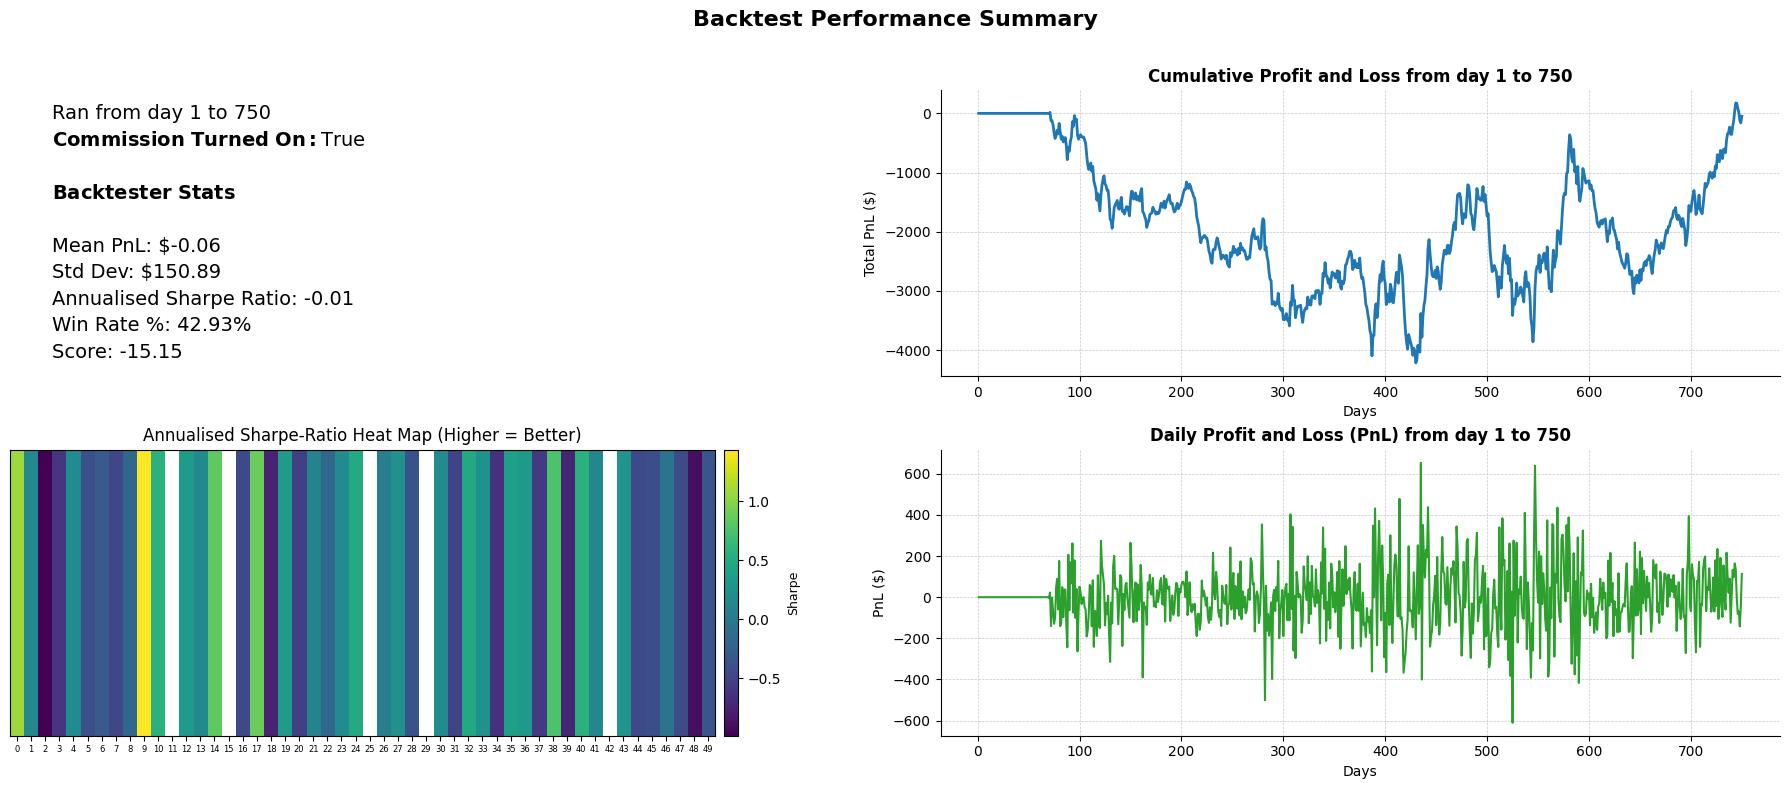

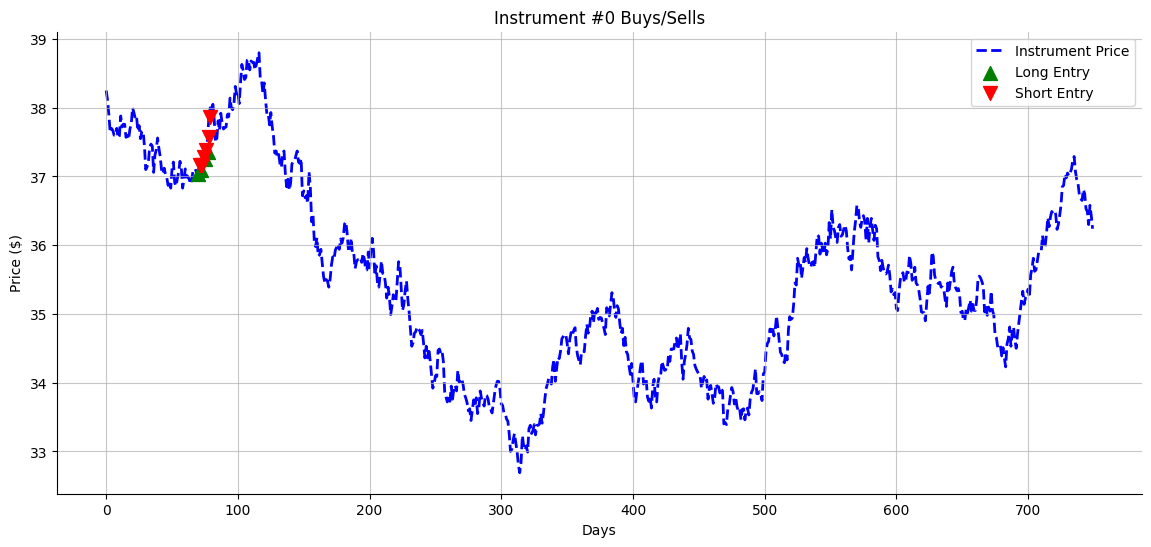

In [12]:
params = backtester.Params(
    strategy_function=getMyPosition,
    start_day=1,
    end_day=750,
    enable_commission=True,
    graphs=["cum-pnl", "sharpe-heat-map", "daily-pnl"]
)

bt = backtester.Backtester(params)
results = bt.run(start_day=1, end_day=750)
bt.show_dashboard(results, graphs=params.graphs)
bt.show_price_entries(results)